In [1]:
#!/usr/bin/env python
# coding:utf-8

"""
function: 
@author: zkang kai
@contact: 474918208@qq.com
"""

import requests
import pandas as pd
from bs4 import BeautifulSoup
import tushare as ts
import openpyxl as oxl
import os
from collections import OrderedDict
import datetime
import json
import wx
import wx.richtext as rt
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select
import matplotlib.pyplot as plt
import numpy as np

url = r"http://www.hkexnews.hk/sdw/search/searchsdw_c.aspx"

def update(event):
    '''
    更新数据
    '''
    name_dict = config_dict.get('name_dict',{})
    first_all_data = config_dict['first_all_data']
    first_all_data = pd.read_json(first_all_data)
    second_all_data = config_dict['second_all_data']
    second_all_data = pd.read_json(second_all_data)

    begin_date = ui_begin_date.GetValue()
    end_date = ui_end_date.GetValue()

    if len(begin_date) != 8 and len(end_date) != 8:
        contents.SetValue("日期格式不对,请参照:20180101填写")
        return None

    begin_date = begin_date[0:4] + '-' + begin_date[4:6] + '-' + begin_date[6:8]
    end_date = end_date[0:4] + '-' + end_date[4:6] + '-' + end_date[6:8]

    already_begin_date = config_dict.get('already_begin_date',begin_date)
    already_end_date = config_dict.get('already_end_date',end_date)

    trade_cal = config_dict['trade_cal']
    trade_cal = pd.read_json(trade_cal)
    trade_cal = trade_cal.sort_index()
    trade_cal = trade_cal[trade_cal['calendarDate'] >= begin_date]
    trade_cal = trade_cal[trade_cal['calendarDate'] <= end_date]
    trade_cal = trade_cal[trade_cal['isOpen'] == 1]
    trade_cal = trade_cal['calendarDate']

    browser = webdriver.Chrome()
    browser.get(url)

    for temp_time in trade_cal:

        if temp_time in config_dict:
            continue
    
        select = Select(browser.find_element_by_name('ddlShareholdingMonth'))
        select.select_by_value(temp_time[5:7])

        select = Select(browser.find_element_by_name('ddlShareholdingDay'))
        select.select_by_value(temp_time[8:10])

        select = Select(browser.find_element_by_name('ddlShareholdingYear'))
        select.select_by_value(temp_time[0:4])

        element = browser.find_element_by_id("txtStockCode")
        element.send_keys("91888")

        browser.find_element_by_id("btnSearch").click()

        html_txt = browser.page_source

        soup = BeautifulSoup(html_txt,'html.parser')

        first_part = get_first_part(soup,temp_time)
        second_part = get_second_part(soup,temp_time)
        first_all_data = first_part.append(first_all_data) 
        second_all_data = second_part.append(second_all_data) 

        config_dict[temp_time] = [first_part.to_json(),second_part.to_json()] 
        browser.back() 

    
    browser.close()
    first_all_data = first_all_data.sort_index(ascending=False)
    second_all_data = second_all_data.sort_index(ascending=False)
    second_all_data = second_all_data.fillna(0)

    already_begin_date = first_all_data.index[-1].date().isoformat()
    already_end_date = first_all_data.index[0].date().isoformat()
    close_data = ts.get_k_data('601888',start=already_begin_date,end=already_end_date)

    config_dict['name_dict'] = name_dict
    config_dict['close_data'] = close_data.to_json()
    config_dict['already_begin_date'] = already_begin_date 
    config_dict['already_end_date'] = already_end_date
    config_dict['first_all_data'] = first_all_data.to_json()
    config_dict['second_all_data'] = second_all_data.to_json()

    with open('config.json','w',encoding='utf-8') as f:
        json.dump(config_dict,f)

    contents.SetValue('更新数据区间为:%s至%s!' % (already_begin_date,already_end_date))

def load_from_local():
    
    with open('__ HKEX __ HKEXnews __.html','r',encoding="utf-8") as f:
        return f.read()

def get_first_part(soup,temp_time):

    temp_html = soup.find("table",{"id":"Table5"})
    temp_html = temp_html.find_all('td',{"class":"arial12black"})

    first_dict = {}
    temp_string = temp_html[1].get_text().strip()
    temp_string = datetime.datetime.strptime(temp_string,"%d/%m/%Y")
    temp_string = temp_string.strftime("%Y-%m-%d")
    #  first_dict['last_date'] = temp_string
    first_dict['stock_code'] = temp_html[3].get_text().strip()
    first_dict['stock_name'] = temp_html[5].get_text().strip()

    temp_html = soup.find("div",{"id":{"pnlResultSummary"}})
    temp_html = temp_html.find_all("span",{"class":"mobilezoom"})

    first_dict = {}
    first_dict['hold_volumn'] = temp_html[0].get_text().strip()
    first_dict['people_number'] = temp_html[1].get_text().strip()
    first_dict['hold_precent'] = temp_html[2].get_text().strip()
    first_dict['all_volumn'] = temp_html[6].get_text().strip()

    return pd.DataFrame(first_dict,index=[pd.Timestamp(temp_time)])

def get_second_part(soup,temp_time):

    name_dict = config_dict.get('name_dict',{})
    temp_html = soup.find("table",{"id":{"participantShareholdingList"}})
    temp_html = temp_html.find_all('tr')

    row_number = len(temp_html)
    col_number = len(temp_html[0].find_all('td'))

    d = {}
    for i in range(col_number):
        d[i] = []

    for i in range(1,row_number):
        temp_tr = temp_html[i]
        temp_td = temp_tr.find_all('td')
    
        if len(temp_td) !=col_number:
            continue
        
        for j in range(col_number):
            temp_string = temp_td[j].get_text().strip()
            d[j].append(temp_string)

    last_pd = pd.DataFrame(d)
    
    last_dict = {}
    for i in range(len(last_pd)):
        last_dict[last_pd.iat[i,0]] = last_pd.iat[i,1]

    name_dict.update(last_dict)

    new_pd = pd.DataFrame(last_pd[3])
    new_pd = new_pd.T
    new_pd.columns = last_pd[0]
    new_pd.index = [pd.Timestamp(temp_time)]

    return new_pd

def write_to_excel(event):
    '''
    把数据写入excle中
    '''
    name_dict = config_dict.get('name_dict',{})
    first_all_data = config_dict['first_all_data']
    first_all_data = pd.read_json(first_all_data)
    
    second_all_data = config_dict['second_all_data']
    second_all_data = pd.read_json(second_all_data)

    close_data = config_dict['close_data']
    close_data = pd.read_json(close_data)
    close_data = close_data['close']

    hold_volumn = first_all_data['hold_volumn']
    people_number = first_all_data['people_number']
    hold_precent = first_all_data['hold_precent']
    all_volumn = first_all_data['all_volumn']

    first_all_data = first_all_data.sort_index(ascending=False)
    second_all_data = second_all_data.sort_index(ascending=False)
    close_data = close_data.sort_index(ascending=False)

    wb = oxl.Workbook()
    ws = wb.create_sheet(index=0,title='oxl-sheet')

    columns = second_all_data.columns
    index = first_all_data.index
    row_number = len(index)
    col_number = len(columns)
    
    ws.cell(row=2,column=1).value = '日期'
    ws.cell(row=2,column=2).value = '收盘价'
    #  ws.cell(row=2,column=3).value = '股票代码'
    #  ws.cell(row=2,column=4).value = '股票名称'
    ws.cell(row=2,column=3).value = '中央结算系统持股量'
    ws.cell(row=2,column=4).value = '参与者数目'
    ws.cell(row=2,column=5).value = '总数百分比'
    ws.cell(row=2,column=6).value = '全部持股量'
    
    for i in range(row_number):
        ws.cell(row=i+3,column=1).value = index[i].date().isoformat()
        ws.cell(row=i+3,column=2).value = close_data.iat[i]
        ws.cell(row=i+3,column=3).value = hold_volumn.iat[i]
        ws.cell(row=i+3,column=4).value = people_number.iat[i]
        ws.cell(row=i+3,column=5).value = hold_precent.iat[i]
        ws.cell(row=i+3,column=6).value = all_volumn.iat[i]

    for i in range(col_number):
        ws.cell(row=2,column=i+7).value = columns[i]
        ws.cell(row=1,column=i+7).value = name_dict[columns[i]] 

    for i in range(row_number):
        for j in range(col_number):
            ws.cell(row=3+i,column=j+7).value = second_all_data.iat[i,j]

    wb.save('test.xlsx')
    contents.SetValue(r"数据已写入excel中!")

def get_close_data():
    '''
    获取收盘价数据
    '''

    close_data = config_dict['close_data']
    close_data = pd.read_json(close_data)
    close_data.index = close_data['date']
    #  close_data = close_data.sort_index()
    return close_data['close']

def get_second_all_data():
    '''
    获取第二部分数据
    '''
    second_all_data = config_dict['second_all_data']
    second_all_data = pd.read_json(second_all_data)
    #  second_all_data = second_all_data.sort_index()
    
    return second_all_data

def get_first_all_data():
    '''
    获取第一部分数据
    '''

    first_all_data = config_dict['first_all_data']
    first_all_data = pd.read_json(first_all_data)
    #  first_all_data = first_all_data.sort_index()
    return first_all_data


def plot_10(event):
    '''
    画前10大持仓股的曲线图
    '''
    close_data = get_close_data()
    second_all_data = get_second_all_data()

    for i in range(len(second_all_data.columns)):
        if np.issubdtype(second_all_data.iloc[:,i],np.object_):
            second_all_data.iloc[:,i] = pd.to_numeric(second_all_data.iloc[:,i].str.replace(',', ''))

    close_data = close_data.sort_index()
    second_all_data = second_all_data.sort_index()
    second_all_data = second_all_data.sort_values(second_all_data.index[-1],axis=1,ascending=False)

    for i in range(10):
        temp_col = second_all_data.iloc[:,i]
        fig, ax1 = plt.subplots()
        #plt.plot(l2,lw=1.5, label='close')
        temp_col.plot(lw=1.5,label='volumn')
        plt.grid(True)
        plt.legend(loc=2)
        plt.axis('tight')
        plt.xlabel('index')
        plt.ylabel('volumn')

        ax2 = ax1.twinx()
        plt.plot(close_data, 'g',lw=1.5, label='close')
        plt.legend(loc=1)
        plt.ylabel('close')
        plt.title(temp_col.name)
        plt.savefig(str(i)+'.png')
    
    contents.SetValue(r"画图成功!")

def init():
    '''
    初始化数据变量
    '''
    if os.path.exists('config.json'):
        with open('config.json','r',encoding='utf-8') as f:
            config_dict = json.load(f)
            contents.SetValue(r"当前数据区间为:%s至%s" % (config_dict['already_begin_date'],config_dict['already_end_date']))
            ui_begin_date.SetValue(config_dict['already_begin_date'])
            ui_end_date.SetValue(config_dict['already_end_date'])
    else:
        config_dict = {}
        config_dict['trade_cal'] = ts.trade_cal().to_json()
        config_dict['name_dict'] = {}
        first_all_data = pd.DataFrame()
        config_dict['first_all_data'] = first_all_data.to_json()
        second_all_data = pd.DataFrame()
        config_dict['second_all_data'] = second_all_data.to_json()
        contents.SetValue(r"当前未拥有任何数据")

    return config_dict


In [2]:
url = "http://finance.sina.com.cn/iframe/futures_info_cff.js"

In [5]:
url1 = "http://www.shfe.com.cn/bourseService/businessdata/summaryinquiry/index.html?paramid=trading_daily"

In [3]:
r = requests.get(url)

In [4]:
r.text

'var JYS = new Array;\r\nvar PZ = new Array;\r\nvar YF = new Array;\r\nJYS[0] = "交易所";\r\nPZ[0] = new Array;\r\nYF[0] = new Array;\r\nPZ[0][0] = "品种";\r\nYF[0][0] = new Array;\r\nYF[0][0][0] = new Array("合约","RB1810");\r\nJYS[1] = \'上期所\';\r\nPZ[1] = new Array;\r\nYF[1] = new Array;\r\nPZ[1][0] = "螺纹钢";\r\nYF[1][0] = new Array;\r\nYF[1][0][0] = new Array("螺纹钢连续","RB0");\r\nYF[1][0][1] = new Array("螺纹钢1807","RB1807");\r\nYF[1][0][2] = new Array("螺纹钢1808","RB1808");\r\nYF[1][0][3] = new Array("螺纹钢1809","RB1809");\r\nYF[1][0][4] = new Array("螺纹钢1810","RB1810");\r\nYF[1][0][5] = new Array("螺纹钢1811","RB1811");\r\nYF[1][0][6] = new Array("螺纹钢1812","RB1812");\r\nYF[1][0][7] = new Array("螺纹钢1901","RB1901");\r\nYF[1][0][8] = new Array("螺纹钢1902","RB1902");\r\nYF[1][0][9] = new Array("螺纹钢1903","RB1903");\r\nYF[1][0][10] = new Array("螺纹钢1904","RB1904");\r\nYF[1][0][11] = new Array("螺纹钢1905","RB1905");\r\nYF[1][0][12] = new Array("螺纹钢1906","RB1906");\r\nPZ[1][1] = "线材";\r\nYF[1][1] = new Array;\r\n

In [23]:
len(list1)

672

In [28]:
s2 = list1[15]

In [29]:
s2

'YF[1][0][1] = new Array("螺纹钢1807","RB1807");'

In [31]:
s2.find('new Array(')

14

In [74]:
s3 = 'new Array("合约","RB1810");'

In [69]:
s3 = 'new Array'

In [40]:
s3.find('"',25)

27

In [41]:
import re

In [76]:
s4 = 'new Array\\("(.+)","(.+)"\\);'

In [67]:
s4 = 'ne';

In [77]:
s5 = re.compile(s4)

In [75]:
print(s5.match(s3))

<_sre.SRE_Match object; span=(0, 2), match='ne'>


In [85]:
s5.findall(temp)

[('合约', 'RB1810'),
 ('螺纹钢连续', 'RB0'),
 ('螺纹钢1807', 'RB1807'),
 ('螺纹钢1808', 'RB1808'),
 ('螺纹钢1809', 'RB1809'),
 ('螺纹钢1810', 'RB1810'),
 ('螺纹钢1811', 'RB1811'),
 ('螺纹钢1812', 'RB1812'),
 ('螺纹钢1901', 'RB1901'),
 ('螺纹钢1902', 'RB1902'),
 ('螺纹钢1903', 'RB1903'),
 ('螺纹钢1904', 'RB1904'),
 ('螺纹钢1905', 'RB1905'),
 ('螺纹钢1906', 'RB1906'),
 ('线材连续', 'WR0'),
 ('线材1807', 'WR1807'),
 ('线材1808', 'WR1808'),
 ('线材1809', 'WR1809'),
 ('线材1810', 'WR1810'),
 ('线材1811', 'WR1811'),
 ('线材1812', 'WR1812'),
 ('线材1901', 'WR1901'),
 ('线材1902', 'WR1902'),
 ('线材1903', 'WR1903'),
 ('线材1904', 'WR1904'),
 ('线材1905', 'WR1905'),
 ('线材1906', 'WR1906'),
 ('沪铜连续', 'CU0'),
 ('沪铜1807', 'CU1807'),
 ('沪铜1808', 'CU1808'),
 ('沪铜1809', 'CU1809'),
 ('沪铜1810', 'CU1810'),
 ('沪铜1811', 'CU1811'),
 ('沪铜1812', 'CU1812'),
 ('沪铜1901', 'CU1901'),
 ('沪铜1902', 'CU1902'),
 ('沪铜1903', 'CU1903'),
 ('沪铜1904', 'CU1904'),
 ('沪铜1905', 'CU1905'),
 ('沪铜1906', 'CU1906'),
 ('沪铝连续', 'AL0'),
 ('沪铝1807', 'AL1807'),
 ('沪铝1808', 'AL1808'),
 ('沪铝1809', 'AL1809'),

In [81]:
s5.search(temp).group(2)

'RB1810'

In [6]:
temp = r.text

In [18]:
list1 = temp.split('\r\n')

In [88]:
temp = set()
for i in list1:
    m = s5.search(i)
    if m:
        print(m.group(2))
        temp.add(m.group(2))

        

RB1810
RB0
RB1807
RB1808
RB1809
RB1810
RB1811
RB1812
RB1901
RB1902
RB1903
RB1904
RB1905
RB1906
WR0
WR1807
WR1808
WR1809
WR1810
WR1811
WR1812
WR1901
WR1902
WR1903
WR1904
WR1905
WR1906
CU0
CU1807
CU1808
CU1809
CU1810
CU1811
CU1812
CU1901
CU1902
CU1903
CU1904
CU1905
CU1906
AL0
AL1807
AL1808
AL1809
AL1810
AL1811
AL1812
AL1901
AL1902
AL1903
AL1904
AL1905
AL1906
RU0
RU1807
RU1808
RU1809
RU1810
RU1811
RU1901
RU1903
RU1904
RU1905
RU1906
FU0
FU1808
FU1809
FU1810
FU1811
FU1812
FU1901
FU1903
FU1904
FU1905
FU1906
FU1907
ZN0
ZN1807
ZN1808
ZN1809
ZN1810
ZN1811
ZN1812
ZN1901
ZN1902
ZN1903
ZN1904
ZN1905
ZN1906
AU0
AU1807
AU1808
AU1809
AU1810
AU1812
AU1902
AU1904
AU1906
AG0
AG1807
AG1808
AG1809
AG1810
AG1811
AG1812
AG1901
AG1902
AG1903
AG1904
AG1905
AG1906
BU0
BU1807
BU1808
BU1809
BU1810
BU1811
BU1812
BU1903
BU1906
BU1909
BU1912
HC0
HC1807
HC1808
HC1809
HC1810
HC1811
HC1812
HC1901
HC1902
HC1903
HC1904
HC1905
HC1906
HC1907
NI0
NI1807
NI1808
NI1809
NI1810
NI1811
NI1812
NI1901
NI1902
NI1903
NI1904
NI1905


In [89]:
temp

{'A0',
 'A1809',
 'A1811',
 'A1901',
 'A1903',
 'A1905',
 'A1907',
 'A1909',
 'A1911',
 'AG0',
 'AG1807',
 'AG1808',
 'AG1809',
 'AG1810',
 'AG1811',
 'AG1812',
 'AG1901',
 'AG1902',
 'AG1903',
 'AG1904',
 'AG1905',
 'AG1906',
 'AL0',
 'AL1807',
 'AL1808',
 'AL1809',
 'AL1810',
 'AL1811',
 'AL1812',
 'AL1901',
 'AL1902',
 'AL1903',
 'AL1904',
 'AL1905',
 'AL1906',
 'AP0',
 'AP1807',
 'AP1810',
 'AP1811',
 'AP1812',
 'AP1901',
 'AP1903',
 'AP1905',
 'AU0',
 'AU1807',
 'AU1808',
 'AU1809',
 'AU1810',
 'AU1812',
 'AU1902',
 'AU1904',
 'AU1906',
 'B0',
 'B1807',
 'B1809',
 'B1811',
 'B1901',
 'B1903',
 'B1905',
 'BB0',
 'BB1807',
 'BB1808',
 'BB1809',
 'BB1810',
 'BB1811',
 'BB1812',
 'BB1901',
 'BB1902',
 'BB1903',
 'BB1904',
 'BB1905',
 'BB1906',
 'BB1907',
 'BU0',
 'BU1807',
 'BU1808',
 'BU1809',
 'BU1810',
 'BU1811',
 'BU1812',
 'BU1903',
 'BU1906',
 'BU1909',
 'BU1912',
 'C0',
 'C1807',
 'C1809',
 'C1811',
 'C1901',
 'C1903',
 'C1905',
 'CF0',
 'CF1807',
 'CF1809',
 'CF1811',
 'CF1901

In [130]:
with open('temp.txt','w') as f:
    #f.writelines(temp)
    for i in temp:
        f.write(str(i)+'\n')

In [132]:
with open('temp.txt','r') as f:
    for line in f:
        line

In [120]:
ss1

'JR1901\nRB1811\nAG0\nRU1808\nIH1808\nPB1904\nCS1807\nCF1903\nZN1901\nPB1903\nPP1903\nJR1811\nAG1808\nRU1904\nBU0\nNI1808\nPP1809\nJ1811\nNI1902\nAP1903\nRI1809\nAG1901\nRI1811\nWR1807\nRB1808\nI1809\nP1812\nHC1904\nNI1905\nSN1905\nC1905\nAL1902\nSM1901\nNI1907\nSR1909\nPP1810\nWR1905\nZC1810\nA0\nCF1809\nSM1808\nI1905\nM1807\nI0\nRB1901\nFB1807\nY1808\nMA1903\nTA1902\nBB1901\nV0\nWH1909\nJ1810\nTF1812\nFU1810\nMA1809\nCU1902\nV1904\nIC0\nBU1906\nAP1812\nWH1901\nRU1811\nV1812\nMA1811\nRI1903\nNI1904\nAL1904\nBB1807\nWR1808\nSR1809\nRM1808\nAG1811\nWH1911\nAL1810\nBB1810\nWR0\nJ1809\nOI1901\nL1906\nIC1809\nL1902\nAP1901\nPB1906\nCS1809\nFG1902\nM1808\nFG1810\nLR1907\nBU1903\nFG1809\nSN1811\nRU1905\nZN1906\nJM1810\nJ1906\nHC1809\nSF1809\nCS1901\nJM1904\nI1907\nJR1809\nZC1808\nWR1906\nM1905\nV1807\nJD1809\nAU1902\nAU1904\nLR1903\nPB1807\nRB1812\nBB1902\nC1811\nSF1808\nTA1901\nAU1810\nC1903\nOI1809\nFG1901\nJM1807\nZN1807\nBB1907\nB1903\nRB1905\nPP1901\nFB1812\nA1911\nCU1904\nIH1809\nV1903

In [16]:
list1

['var JYS = new Array;',
 'var PZ = new Array;',
 'var YF = new Array;',
 'JYS[0] = "交易所";',
 'PZ[0] = new Array;',
 'YF[0] = new Array;',
 'PZ[0][0] = "品种";',
 'YF[0][0] = new Array;',
 'YF[0][0][0] = new Array("合约","RB1810");',
 "JYS[1] = '上期所';",
 'PZ[1] = new Array;',
 'YF[1] = new Array;',
 'PZ[1][0] = "螺纹钢";',
 'YF[1][0] = new Array;',
 'YF[1][0][0] = new Array("螺纹钢连续","RB0");',
 'YF[1][0][1] = new Array("螺纹钢1807","RB1807");',
 'YF[1][0][2] = new Array("螺纹钢1808","RB1808");',
 'YF[1][0][3] = new Array("螺纹钢1809","RB1809");',
 'YF[1][0][4] = new Array("螺纹钢1810","RB1810");',
 'YF[1][0][5] = new Array("螺纹钢1811","RB1811");',
 'YF[1][0][6] = new Array("螺纹钢1812","RB1812");',
 'YF[1][0][7] = new Array("螺纹钢1901","RB1901");',
 'YF[1][0][8] = new Array("螺纹钢1902","RB1902");',
 'YF[1][0][9] = new Array("螺纹钢1903","RB1903");',
 'YF[1][0][10] = new Array("螺纹钢1904","RB1904");',
 'YF[1][0][11] = new Array("螺纹钢1905","RB1905");',
 'YF[1][0][12] = new Array("螺纹钢1906","RB1906");',
 'PZ[1][1] = "线材";',


In [11]:
temp.find('new Array(')

AttributeError: 'str' object has no attribute 'findall'

In [ ]:
if __name__ == '__main__':

    app = wx.App()

    win = wx.Frame(None,title="simple editor",size=(430,200))

    begin_button = wx.Button(win,label='更新数据',pos=(160,10),size=(60,45))
    begin_button.Bind(wx.EVT_BUTTON,update)
    save_button = wx.Button(win,label='写入excle',pos=(240,10),size=(60,45))
    save_button.Bind(wx.EVT_BUTTON,write_to_excel)
    plot_button = wx.Button(win,label='画图',pos=(320,10),size=(60,45))
    plot_button.Bind(wx.EVT_BUTTON,plot_10)

    ui_label1 = wx.StaticText(win, label = "起始日期", pos = (5,5)) 
    ui_label2 = wx.StaticText(win, label = "终止日期", pos = (5,35)) 

    ui_begin_date = wx.TextCtrl(win,pos=(60,5),size=(90,25))
    ui_end_date = wx.TextCtrl(win,pos=(60,35),size=(90,25))

    contents = wx.TextCtrl(win,pos=(5,70),size=(390,80),style=rt.RE_READONLY)
    config_dict = init()

    win.Show()
    app.MainLoop()

In [14]:
with open('../web/601088.json','r',encoding='utf-8') as f:
        config_dict = json.load(f)

name_dict = config_dict.get('name_dict',{})
first_all_data = config_dict['first_all_data']
first_all_data = pd.read_json(first_all_data)
second_all_data = config_dict['second_all_data']
second_all_data = pd.read_json(second_all_data)

already_begin_date = config_dict.get('already_begin_date')
already_end_date = config_dict.get('already_end_date')

close_data = config_dict['close_data']
close_data = pd.read_json(close_data)
close_data = close_data['close']

In [28]:
 for i in range(len(second_all_data.columns)):
        if np.issubdtype(second_all_data.iloc[:,i],np.object_):
            second_all_data.iloc[:,i] = pd.to_numeric(second_all_data.iloc[:,i].str.replace(',', ''))

close_data = close_data.sort_index()
second_all_data = second_all_data.sort_index()
second_all_data = second_all_data.sort_values(second_all_data.index[-1],axis=1,ascending=False)

In [30]:
myfont = mpl.font_manager.FontProperties(fname="simhei.ttf")
mpl.rcParams['axes.unicode_minus'] = False

In [20]:
name_dict

{'B01086': '新鴻基投資服務有限公司',
 'B01089': '匯豐金融證券(香港)有限公司',
 'B01110': 'J.P. MORGAN BROKING (HONG KONG) LTD',
 'B01115': '申萬宏源證券(香港)有限公司',
 'B01119': '時富證券有限公司',
 'B01121': '法國興業證券(香港)有限公司',
 'B01130': '中銀國際證券有限公司',
 'B01138': '中信里昂證券有限公司',
 'B01143': '海通國際證券有限公司',
 'B01148': '招商證券(香港)有限公司',
 'B01161': 'UBS SECURITIES HONG KONG LTD',
 'B01224': 'MLFE LTD',
 'B01228': '中信証券經紀(香港)有限公司',
 'B01256': '國金證券(香港)有限公司',
 'B01264': '金英證券(香港)有限公司',
 'B01274': 'MORGAN STANLEY HONG KONG SECURITIES LTD',
 'B01284': '恒生證券有限公司',
 'B01323': '德意志證券亞洲有限公司',
 'B01345': '輝立証券(香港)有限公司',
 'B01353': '大華繼顯(香港)有限公司',
 'B01355': '中國光大證券(香港)有限公司',
 'B01372': '第一金和昇證券有限公司',
 'B01413': '京華山一國際(香港)有限公司',
 'B01434': '蜂投證券有限公司',
 'B01451': '高盛(亞洲)證券有限公司',
 'B01491': 'CREDIT SUISSE SECURITIES (HONG KONG) LTD',
 'B01497': '永豐金證券(亞洲)有限公司',
 'B01556': '六福證券(香港)有限公司',
 'B01565': '國泰君安證券(香港)有限公司',
 'B01584': '致富證券有限公司',
 'B01590': '盈透證券香港有限公司',
 'B01610': '凱基證券亞洲有限公司',
 'B01654': '中國國際金融香港證券有限公司',
 'B01668': '耀才證券國際(香港)有限公司',
 '

In [42]:
temp_company = '香港上海匯豐銀行有限公司'
temp_name = [k for k,v in name_dict.items() if v == temp_company]
temp_col = second_all_data.loc[:,temp_name]

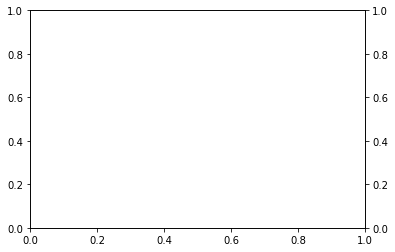

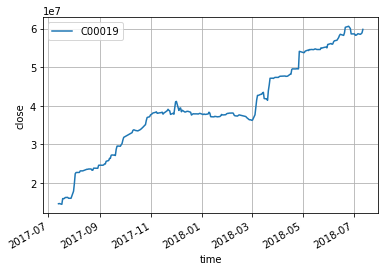

In [52]:
fig,ax1 = plt.subplots()
temp_col.plot(lw=1.5,label='volumn')
plt.grid(True)
plt.legend(loc=2)
plt.axis('tight')
plt.xlabel('time')
plt.ylabel('volumn')

ax2 = ax1.twinx()
plt.plot(close_data, 'g',lw=1.5, label='close')
plt.ylabel('close')
plt.show()

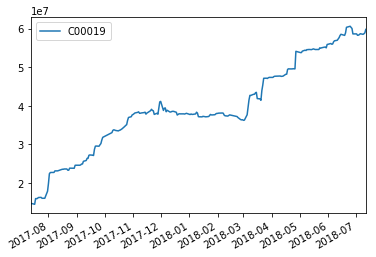

In [49]:
temp_col.plot(lw=1.5,label='volumn')

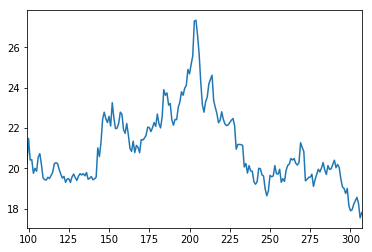

In [32]:

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(temp_col,'b',lw=1.5,label='volumn')
ax2.plot(close_data,'g',lw=1.5,label='close')

ax1.set_xlabel('time')
ax1.set_ylabel('volume')
ax2.set_ylabel('close')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.grid(True)

    #  p1 = temp_col.plot(lw=1.5,label='volumn')
    #  plt.legend(loc=2)
    #  plt.axis('tight')
    #  plt.xlabel('time')
    #  plt.ylabel('volumn')
    #
    #  p2 = close_data.plot(lw=1.5,label='close')
    #  #  plt.plot(close_data, 'g',lw=1.5, label='close')
    #  plt.legend(loc=1)
    #  plt.ylabel('close')
    #plt.title(temp_company,fontproperties=myfont)
    plt.show()
    #plt.savefig("./"+sh_code+"/"+company_combox.GetStringSelection()+'.png')


ValueError: ordinal must be >= 1

In [12]:
today_date = datetime.date.today()

In [13]:
min_date = datetime.date(today_date.year-1,today_date.month,today_date.day)

In [14]:
max_date = today_date - datetime.timedelta(1)

In [ ]:
    trade_cal = config_dict['trade_cal']
    trade_cal = pd.read_json(trade_cal)
    trade_cal = trade_cal.sort_index()
    trade_cal = trade_cal[trade_cal['calendarDate'] >= begin_date]
    trade_cal = trade_cal[trade_cal['calendarDate'] <= end_date]
    trade_cal = trade_cal[trade_cal['isOpen'] == 1]
    trade_cal = trade_cal['calendarDate']

In [27]:
datetime.datetime.strptime('2018-06-22','%Y-%m-%d')

datetime.datetime(2018, 6, 22, 0, 0)

In [25]:
pd.to_datetime(trade_cal['calendarDate'])

0       1990-12-19
1       1990-12-20
2       1990-12-21
3       1990-12-22
4       1990-12-23
5       1990-12-24
6       1990-12-25
7       1990-12-26
8       1990-12-27
9       1990-12-28
10      1990-12-29
11      1990-12-30
12      1990-12-31
13      1991-01-01
14      1991-01-02
15      1991-01-03
16      1991-01-04
17      1991-01-05
18      1991-01-06
19      1991-01-07
20      1991-01-08
21      1991-01-09
22      1991-01-10
23      1991-01-11
24      1991-01-12
25      1991-01-13
26      1991-01-14
27      1991-01-15
28      1991-01-16
29      1991-01-17
           ...    
10210   2018-12-02
10211   2018-12-03
10212   2018-12-04
10213   2018-12-05
10214   2018-12-06
10215   2018-12-07
10216   2018-12-08
10217   2018-12-09
10218   2018-12-10
10219   2018-12-11
10220   2018-12-12
10221   2018-12-13
10222   2018-12-14
10223   2018-12-15
10224   2018-12-16
10225   2018-12-17
10226   2018-12-18
10227   2018-12-19
10228   2018-12-20
10229   2018-12-21
10230   2018-12-22
10231   2018

In [23]:
trade_cal

,calendarDate,isOpen
0,1990-12-19,1
1,1990-12-20,1
2,1990-12-21,1
3,1990-12-22,0
4,1990-12-23,0
5,1990-12-24,1
6,1990-12-25,1
7,1990-12-26,1
8,1990-12-27,1
9,1990-12-28,1


In [6]:
help(datetime.timedelta)

Help on class timedelta in module datetime:

class timedelta(builtins.object)
 |  Difference between two datetime values.
 |  
 |  Methods defined here:
 |  
 |  __abs__(self, /)
 |      abs(self)
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __divmod__(self, value, /)
 |      Return divmod(self, value).
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __floordiv__(self, value, /)
 |      Return self//value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __le__(self, value, /)
 |      Return self<=value.
 |  
 |  __lt__(self, value, /)
 |      Return self<value.
 |  
 |  __mod__(self, value, /)
 |      Return self%value.
 |  
 |  __mul__(self, value, /)
 |      Return self*value.
 |  
 |  __

In [149]:
first_all_data = config_dict['first_all_data']

In [163]:
close_data = config_dict['close_data']
close_data = pd.read_json(close_data)

In [167]:
close_data = close_data.sort_index()

In [170]:
close_data = close_data['close']

In [165]:
close_data.index = close_data['date']

In [150]:
first_all_data = pd.read_json(first_all_data)

In [12]:
temp = first_all_data.sort_index(ascending=False)

In [173]:
second_all_data = config_dict['second_all_data']

In [174]:
second_all_data = pd.read_json(second_all_data)

In [156]:
second_all_data.index[0].date().isoformat()

'2018-06-11'

In [27]:
np.issubdtype(second_all_data.iloc[:,40],np.object_)

True

In [41]:
temp = second_all_data.sort_values(second_all_data.index[0],axis=1,ascending=False)

In [48]:
second_all_data.iloc[:,0:10].plot()

In [73]:
plt.savefig('002.png')

In [86]:
name_dict = config_dict['name_dict']

In [87]:
close_data = config_dict['close_data']

In [88]:
close_data = pd.read_json(close_data)

In [91]:
close_data.index = close_data['date']

In [102]:
close_data = close_data.sort_index()

In [103]:
l2 = close_data['close']

In [14]:
temp1 = temp.to_json()

In [17]:
temp2 = pd.read_json(temp1)

In [36]:
s1 = pd.DataFrame([1,2,3])

In [39]:
config_dict = {}

In [40]:
config_dict['test'] = s1

In [16]:
temp_html = soup.find("table",{"id":{"participantShareholdingList"}})
temp_html = temp_html.find_all('tr')

In [17]:
row_number = len(temp_html)
col_number = len(temp_html[0].find_all('td'))

In [22]:
last_pd = pd.DataFrame(d)

In [26]:
URL = r'http://www.hkexnews.hk/sdw/search/searchsdw_c.aspx'

In [27]:
s=requests.Session()

In [28]:
r=s.get(URL)

In [9]:
soup=BeautifulSoup(r.content,'html.parser')

In [10]:
VIEWSTATE=soup.find(id="__VIEWSTATE")['value']
print(VIEWSTATE)

Ckzs+VaFUEDBzZtKQjL8H1DdOd0DKk5HSQ32/tzS8gH+TO1W2S8tjyZf6hmXM7avS2T/u2jdQlJ5D4T/t0hkQaQlfrd8hQKfLvJKZTYFV9m/kkOQVXsunk3uLA6HnJSrYgJAaXQdxh6mR7NrKIXPi+WK3sSA2FiV36I//ZNpgbyoOW6Cd6NncSNgKzmpxEciVxxErw==


In [11]:
VIEWSTATEGENERATOR=soup.find(id="__VIEWSTATEGENERATOR")['value']
print(VIEWSTATEGENERATOR)

3B50BBBD


In [12]:
EVENTVALIDATION=soup.find(id="__EVENTVALIDATION")['value']
print(EVENTVALIDATION)

EDddx7fxnrdp/107CfB06ZyVcpdsQh9RV/LJjPEi4kbot5/97UrfaR99PeyxiM0tTpGLNDIJOMduS3rr1uXADZL/I2jcKp2Sj3Mw4wy1o0XeVqPB+Ph1C8fhhgd8YsPk4GZnMDLxjMhsp29QaVP7k4kgI427pwByQ4jjfdTmtMVNMDW4Ip435K0JLZTw0EauEs7LL627OdvXycUt/qQDkxj3drqss2VFubwySNJUsGfq7+nJmfikzGY2kyzMkC21ZtlCTUZBRtI/eHCl1WLrI/PPw3gKGf98ZuCRX2Wkg4FPsclYQhpCJEVKstDgaTzvDjy2RovMl2XKnR+nasAkeJUtCjx3AV4icTybEjerLsC5bsaRh+bR9UwQim4oQgqgV7Y4dOlrMrW0xCJjAmXOAEQ/V2+5ur8+kcQDLxkD3OiVCSLeasSxnqujO0cjNpe+IkKom0hI+C/j8mN5K4u/e+b5O/SI+a9yuHJfm6ONpNNPmP2aqiW3Dx0diudOvUfsRFC1dS7RTejDbrDPhCiHsIYGJF6CodoqNBjJjAZAoe8Tjsmif4eUn3c/VWKDUC9b8ZjYfjmWEn3TIyhb7Oiq8tKsZtlVhqWh716Rpi5o1uFyztFtd7lBF9DsHh1dv0kGxDbksZj3pI/hgWy2k80vpVilcqaawVmNZqR+PPA/UT97dUANMB6njkPxbwP8p2xRTyQDWZB1z9XAbgBBlPtmdp2RZUH37OWrC44938bj0dJyG3YyRQ2VsdZfGWuU9vgC4S11UlVlqh/+1woZytJmPOgUUd2La1v3fOAmgOTr1AHvZjIUesJVmQPtYpNW6wuIWPIh8ybAg1Ph560omCqiZVswSANAvcJKMEhO3hCUhcapl4Bq1Sh5kCv4p2YCtTuP9i5HRbn/kfLnBhE+bfila3hbMp2roKj8kk0uKeASpfeXbnZgvIbr713fEUnTj9LjcTZ2WLJ0dvLE/xgoLNaoOQyx1wyPyh61Yur4Dkih

In [13]:
login_data={
"__VIEWSTATE":VIEWSTATE,
"__VIEWSTATEGENERATOR":VIEWSTATEGENERATOR,
"__EVENTVALIDATION":EVENTVALIDATION,
"ddlShareholdingDay":'21',
"ddlShareholdingMonth":'06',
"ddlShareholdingYear":"2018",
'txtStockCode':'91888'
           }


In [14]:
r=s.post(URL, data=login_data)

In [35]:
print(driver.find_element_by_id("content").text)

Here is some important text you want to retrieve!
A button to click!


In [4]:
browser = webdriver.Chrome()

In [13]:
browser.get("http://www.hkexnews.hk/sdw/search/searchsdw_c.aspx")

In [11]:
from selenium.webdriver.common.keys import Keys

In [15]:
element = browser.find_element_by_id("ddlShareholdingDay")

In [18]:
element = browser.find_element_by_xpath("//select[@name='ddlShareholdingDay']")

In [20]:
all_options = element.find_elements_by_tag_name("option")

In [31]:
browser.find_element_by_id("btnSearch").click()

In [35]:
html_txt = browser.page_source

In [36]:
soup = BeautifulSoup(html_txt,'html.parser')

In [37]:
first_part = get_first_part()
print(first_part)

{'last_date': '2018-06-20', 'stock_code': '91888', 'stock_name': '中國國旅'}


In [40]:
browser.get("http://www.hkexnews.hk/sdw/search/searchsdw_c.aspx")

In [43]:
browser.back()

In [83]:
browser = webdriver.Chrome()
browser.get("http://www.hkexnews.hk/sdw/search/searchsdw_c.aspx")

In [6]:
browser.get("http://www.hkexnews.hk/sdw/search/searchsdw_c.aspx")